In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape

print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


### Project Overview


The goal of this project is to build the generator portion of a GAN Model to generate Monet-style paintings. The goal is that we can construct a DCGAN generator that generates similar enough Monet style images, that the discriminator classifies these fake images as real. Hypothetically, we could then use these DCGAN generated images as supplemental data and labels to a supervised learning problem. 

The included dataset contains 300 existing Monet paintings to serve as the domain for the discriminator to learn from. There are ~7k baseline images that I will train the generator with to produce the fake Monet style paintings; each of these baseline images has a dimension *256x256x3* pixels. 


NOTE: The preprocessing and helper functions used throughout this notebook were laregely adapted from existing online resources that deal with image processing 

#### Loading in images

In [16]:
# load and preprocess the TFRecord datasets
AUTOTUNE = -1
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_dataset(file_patterns):
    files = []
    for pattern in file_patterns:
        files.extend(tf.data.Dataset.list_files(pattern))
    
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

source_file_patterns = ["/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec"] 
monet_file_patterns = ["/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec"]

source_dataset = load_dataset(source_file_patterns)
monet_dataset = load_dataset(monet_file_patterns)

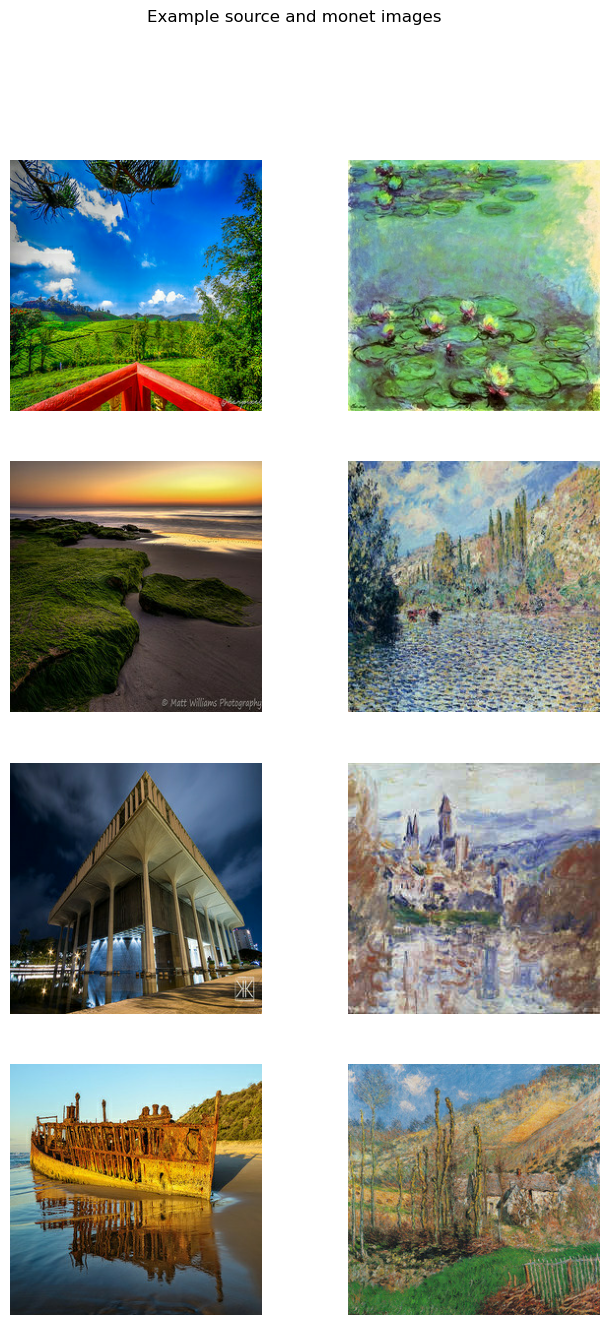

In [24]:
fig, ax = plt.subplots(4, 2, figsize=(8, 15))
fig.suptitle("Example source and monet images")

for i in range(4):
    sample_source_img = next(iter(source_dataset))
    sample_monet_img = next(iter(monet_dataset))
    ax[i, 0].imshow(sample_source_img[0])
    ax[i, 1].imshow(sample_monet_img[0])
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.show()

### Building the Discriminators and Generators

In [27]:
def downsample(filters, size, normalize=True):
    intializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=intializer, use_bias=False))
    if normalize:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=intializer))
    
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    return model


def upsampling(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0., .02)
    model = tf.keras.Sequential()
    model.add(
    keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same', kernel_initializer=initializer,use_bias=False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    if dropout:
        model.add(keras.layers.Dropout(.5))

    model.add(keras.layers.ReLU())
    return model


def build_generator():
    inputs = keras.layers.Input(shape=[256, 256, 3])
    down_sampling = [
        downsample(64, 4, normalize=False),
        downsample(128, 4,),
        downsample(256, 4,),
        downsample(512, 4,),
        downsample(512, 4,),
    ]
    up_sampling = [
        upsampling(512, 4, dropout=True),
        upsampling(512, 4, dropout=True),
        upsampling(256, 4, dropout=False),
        upsampling(128, 4, dropout=False),
        upsampling(64, 4, dropout=False),
    ]
    
    initializer = tf.random_normal_initializer(0, .02)
    last_layer = keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same")
    output_image = keras.layers.Activation("tanh")
    
    x = inputs
    skips = []
    for down in down_sampling:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_sampling, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])

    x = output_image(last_layer(x))

    return keras.Model(inputs=inputs, outputs=x)


# now for the discriminator, I will use the same downsampling methods from above
def build_discriminator():
    initializer = tf.random_normal_initializer(0., .02)
    gamma_init = keras.initializers.RandomNormal(mean=.0, stddev=.02)

    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)

    zero_pad1 = keras.layers.ZeroPadding2D()(down3)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = keras.layers.LeakyReLU()(norm1)

    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) 

    last = keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inp, outputs=last)


In [28]:
# instantiating generators and discriminators
source_generator = build_generator()
monet_generator = build_generator()

source_discriminator = build_discriminator()
monet_discriminator = build_discriminator()

In [29]:
# Define cycle consistency loss
def cycle_loss(real_images, generated_images):
    loss = tf.reduce_mean(tf.abs(real_images - generated_images))
    return loss

# Define adversarial loss (using binary cross-entropy)
def adversarial_loss(y_true, y_pred):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    return loss

### Training

In [31]:
# Optimizers
generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

@tf.function
def train_step(real_source, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_monet = source_generator(real_source)
        fake_source = monet_generator(real_monet)
        
        # Cycle consistency loss
        cycle_source = source_generator(fake_monet)
        cycle_monet = monet_generator(fake_source)
        
        cycle_loss_source = cycle_loss(real_source, cycle_source)
        cycle_loss_monet = cycle_loss(real_monet, cycle_monet)
        
        total_cycle_loss = cycle_loss_source + cycle_loss_monet
        
        # Adversarial loss
        disc_real_source = source_discriminator(real_source)
        disc_fake_source = source_discriminator(fake_source)
        
        disc_real_monet = monet_discriminator(real_monet)
        disc_fake_monet = monet_discriminator(fake_monet)
        
        gen_loss_source = adversarial_loss(tf.ones_like(disc_fake_source), disc_fake_source)
        gen_loss_monet = adversarial_loss(tf.ones_like(disc_fake_monet), disc_fake_monet)
        
        total_gen_loss = gen_loss_source + gen_loss_monet
        
        # Discriminator loss
        disc_loss_real_source = adversarial_loss(tf.ones_like(disc_real_source), disc_real_source)
        disc_loss_fake_source = adversarial_loss(tf.zeros_like(disc_fake_source), disc_fake_source)
        
        disc_loss_real_monet = adversarial_loss(tf.ones_like(disc_real_monet), disc_real_monet)
        disc_loss_fake_monet = adversarial_loss(tf.zeros_like(disc_fake_monet), disc_fake_monet)
        
        total_disc_loss = (disc_loss_real_source + disc_loss_fake_source + disc_loss_real_monet + disc_loss_fake_monet)
        
    # Update generators and discriminators
    generator_gradients = tape.gradient(total_gen_loss, source_generator.trainable_variables + monet_generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, source_generator.trainable_variables + monet_generator.trainable_variables))
    
    discriminator_gradients = tape.gradient(total_disc_loss, source_discriminator.trainable_variables + monet_discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, source_discriminator.trainable_variables + monet_discriminator.trainable_variables))


num_epochs = 1
for epoch in range(num_epochs):
    for batch_source, batch_monet in zip(source_dataset, monet_dataset):
        train_step(batch_source, batch_monet)
    
    # Print progress, save models, etc.


#### Summary of Generators and Discriminators

In [33]:
print(source_discriminator.summary())
source_generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_21 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_22 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           